# Concluciones del proceso

Durante el segundo cuatrimestre de 2025, se llevaron a cabo 13 envíos semanales de MS a ADRES. A nivel mensual, se glosaron 39 registros en mayo (26 validados, 66.7% de efectividad) , 19 en junio (8 validados, 42.1% de efectividad) , 19 en julio (12 validados, 63.2% de efectividad) , y 19 en agosto (6 validados, 31.6% de efectividad). En total, se glosaron 96 registros, de los cuales 52 se resolvieron dentro del mismo mes, con un promedio de efectividad mensual del 50.9%.

Desglosando por envío, el volumen de glosados varió entre 3 y 35, y la tasa de corrección osciló desde un mínimo del 0% hasta un máximo del 66.7%, con un promedio de 42.6% por ciclo. Este patrón demuestra que los meses con más cortes, como mayo y julio, consiguieron mayores oportunidades de reenvío y, por consiguiente, una mejor limpieza de glosas, mientras que una menor efectividad en junio y agosto se correlaciona con la frecuencia de los envíos en esos meses.

# 1. Modulos

In [51]:
import pandas as pd
import numpy as np
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
import openpyxl
import xlsxwriter
from docx import Document
from datetime import datetime
import matplotlib.pyplot as plt
import squarify
import subprocess
import os
import dataframe_image as dfi
import kaleido

# 2. Rutas y contantes

In [52]:
R_Glosas = r"C:\Users\osmarrincon\OneDrive - uniminuto.edu\Capresoca\AlmostClear\Constantes\Glosas ADRES 2025.xlsx"
R_MS_Neg = r"C:\Users\osmarrincon\OneDrive - uniminuto.edu\Capresoca\AlmostClear\Procesos BDUA\Subsidiados\Procesos BDUA EPS\MS\MS Negado\All_MS_NEG.TXT"
R_MS_Val = r"C:\Users\osmarrincon\OneDrive - uniminuto.edu\Capresoca\AlmostClear\Procesos BDUA\Subsidiados\Procesos BDUA EPS\MS\MS Validados\All_MS_VAL.TXT"

R_Salida = r"C:\Users\osmarrincon\OneDrive - 891856000_CAPRESOCA E P S\Escritorio\Yesid Rincón Z\informes\2025\CTO135.2025 Informe  #9\ACTIVIDAD 14\Analisis detallado MS negados"

# ——————————————————————————————
# 0) Prepara rutas y carpetas
# ——————————————————————————————
graficas_dir = os.path.join(R_Salida, "Graficas")
os.makedirs(graficas_dir, exist_ok=True)

ruta_excel   = os.path.join(R_Salida, "Metricas_Glosas_MS_entrega.xlsx")

In [53]:
# Convertir las constantes a objetos datetime
Mes_Ini = datetime.strptime('01/05/2025', '%d/%m/%Y')
Mes_Fin = datetime.strptime('30/08/2025', '%d/%m/%Y')

# ajusta a tu nombre real
notebook = r"C:\Users\osmarrincon\Documents\capresoca-data-automation\notebooks\Aseguramiento\Inf_Ejec_MS_NEG.ipynb"

In [54]:
type(Mes_Fin)

datetime.datetime

# 3. Cargue de Dataframes 

In [55]:
df_glosas = pd.read_excel(R_Glosas, sheet_name="Glosas de Negocio_BDUA", usecols="A:B", header=0, dtype=str)

Df_MS_Neg = pd.read_csv(R_MS_Neg, sep=',', header=0, dtype=str, encoding='ANSI')
Df_MS_Val = pd.read_csv(R_MS_Val, sep=',', header=0, dtype=str, encoding='ANSI')


# 4. Limpieza de dataframes

## 4.1 dicionario de Glosas

In [56]:
df_glosas.columns = df_glosas.columns.str.strip()
# Reemplazar cadenas vacías que contienen solo espacios por NaN
df_glosas[['Glosa', 'Descripción']] = df_glosas[['Glosa', 'Descripción']].replace(r'^\s*$', np.nan, regex=True)
# Eliminar las filas donde ambas columnas son NaN
df_glosas = df_glosas.dropna(subset=['Glosa', 'Descripción'], how='all')

# Número de registros antes de eliminar duplicados
n_registros_antes = len(df_glosas)
print("Número de registros antes de eliminar duplicados:", n_registros_antes)

# Eliminar duplicados de la columna "Glosa"
df_glosas = df_glosas.drop_duplicates(subset="Glosa")

# Número de registros después de eliminar duplicados
n_registros_despues = len(df_glosas)
print("Número de registros después de eliminar duplicados:", n_registros_despues)


Número de registros antes de eliminar duplicados: 206
Número de registros después de eliminar duplicados: 206


In [57]:
# Calcular la longitud de cada valor de la columna 'Glosa'
lengths = df_glosas['Glosa'].astype(str).str.len()

# Determinar la longitud más frecuente (la modalidad)
majority_length = lengths.mode()[0]
print("Longitud mayoritaria:", majority_length)

# Filtrar las filas donde la longitud es diferente a la mayoritaria
different_rows = df_glosas[lengths != majority_length]
print("Filas con una longitud diferente a la mayoría:")
print(different_rows)

Longitud mayoritaria: 6
Filas con una longitud diferente a la mayoría:
       Glosa  \
159   GN0161   

                                                                                                                                         Descripción  
159  La solicitud de trámite de traslado a la misma entidad, solo es válido si se está activando al usuario. EL usuario debe estar en estado RE, DE.  


## 4.2. MS negado

In [58]:
# Convertir las columnas a formato datetime
Df_MS_Neg['AFL_FECHA_NACIMIENTO'] = pd.to_datetime(Df_MS_Neg['AFL_FECHA_NACIMIENTO'], format='%d/%m/%Y')
Df_MS_Neg['CND_AFL_FECHA_INICIO'] = pd.to_datetime(Df_MS_Neg['CND_AFL_FECHA_INICIO'], format='%d/%m/%Y')
Df_MS_Neg['Fecha_Proceso'] = pd.to_datetime(Df_MS_Neg['Fecha_Proceso'], format='%d/%m/%Y')

In [59]:
print("Número de registros antes de filtrar Fecha proceso:", len(Df_MS_Neg))
# Filtrar registros dentro del rango de fechas
Df_MS_Neg = Df_MS_Neg[(Df_MS_Neg['Fecha_Proceso'] >= Mes_Ini) & (Df_MS_Neg['Fecha_Proceso'] <= Mes_Fin)]
print("Número de registros despues de filtrar fecha proceso:", len(Df_MS_Neg))

Número de registros antes de filtrar Fecha proceso: 22438
Número de registros despues de filtrar fecha proceso: 134


## 4.3 MS validados

In [60]:
# Convertir las columnas a formato datetime
Df_MS_Val['AFL_FECHA_NACIMIENTO'] = pd.to_datetime(Df_MS_Val['AFL_FECHA_NACIMIENTO'], format='%d/%m/%Y')
Df_MS_Val['CND_AFL_FECHA_INICIO'] = pd.to_datetime(Df_MS_Val['CND_AFL_FECHA_INICIO'], format='%d/%m/%Y')
Df_MS_Val['Fecha_Proceso'] = pd.to_datetime(Df_MS_Val['Fecha_Proceso'], format='%d/%m/%Y')

In [61]:
print("Número de registros antes de filtrar Fecha proceso:", len(Df_MS_Val))
# Filtrar registros dentro del rango de fechas
Df_MS_Val = Df_MS_Val[(Df_MS_Val['Fecha_Proceso'] >= Mes_Ini) & (Df_MS_Val['Fecha_Proceso'] <= Mes_Fin)]
print("Número de registros despues de filtrar fecha proceso:", len(Df_MS_Val))

Número de registros antes de filtrar Fecha proceso: 19910
Número de registros despues de filtrar fecha proceso: 373


# 5. Analisis de los Datos

## 5.1. métricas inicales

### 5.1 Cálculo de glosas reales por registro
¿Por qué agrupamos por llave “total” y no por fecha de reporte?

Llave de negocio constante

(ENT_ID, TPS_IDN_ID, HST_IDN_NUMERO_IDENTIFICACION) identifica única e invariablemente a cada afiliado.

Incluir Fecha_Proceso en la llave creararía claves distintas para un mismo usuario en cada envío, rompiendo la trazabilidad.

Fecha_Proceso como dimensión temporal

La usamos fuera de la llave para:

Ordenar cronológicamente las glosas.

Filtrar por cortes (cuatrimestrales, últimos envíos, etc.).

Determinar la “última glosa” de cada afiliado y quién queda pendiente.

Beneficio

Obtenemos métricas globales (total de glosas, promedio de reintentos, registros pendientes) sin fragmentar la identidad.

Podemos profundizar por período sin comprometer la agregación histórica.

In [62]:
# —————————————————————————————————————
# 1) Definir la llave única de afiliado
# —————————————————————————————————————
keys = ["ENT_ID", "TPS_IDN_ID", "HST_IDN_NUMERO_IDENTIFICACION"]

Df_MS_Neg["_key"] = (
    Df_MS_Neg[keys]
      .astype(str)
      .agg('|'.join, axis=1)
)
Df_MS_Val["_key"] = (
    Df_MS_Val[keys]
      .astype(str)
      .agg('|'.join, axis=1)
)

### 5.1.2. Contar cuántas glosas tuvo cada registro

In [63]:
# —————————————————————————————————————
# 2) Contar “glosas reales” en cada fila
# —————————————————————————————————————
def contar_glosas(texto: str) -> int:
    # cada glosa está separada por ';'
    trozos = texto.strip(';').split(';')
    return sum(1 for g in trozos if g)

Df_MS_Neg["n_glosas"] = Df_MS_Neg["GLOSA"].apply(contar_glosas)


### 5.1.3. ¿Cuántos registros terminaron validados?

In [64]:
# —————————————————————————————————————
# 3) Agregar total de glosas por registro
# —————————————————————————————————————
neg_count = (
    Df_MS_Neg
      .groupby("_key")["n_glosas"]
      .sum()
      .rename("total_glosas")
      .reset_index()
)

# Distribución de glosas
print(neg_count["total_glosas"].value_counts().sort_index())

# Promedio de glosas por registro
print("Promedio de glosas por registro:",
      neg_count["total_glosas"].mean())

total_glosas
1     65
2      7
3      4
4      2
6      3
8      2
13     2
Name: count, dtype: int64
Promedio de glosas por registro: 1.8705882352941177


### 5.1.4. ¿Cuántas veces, en promedio, se glosó un registro antes de validarse?

In [65]:
# —————————————————————————————————————
# 4) ¿Cuántos registros terminaron validados?
# —————————————————————————————————————
val_keys = set(Df_MS_Val["_key"])
neg_count["fue_validado"] = neg_count["_key"].isin(val_keys)

print(f"De {len(neg_count)} registros negados, "
      f"{neg_count['fue_validado'].sum()} acabaron validados.")


De 85 registros negados, 58 acabaron validados.


### 5.1.5 Promedio de glosas antes de validar

In [66]:
# —————————————————————————————————————
# 5) Promedio de glosas antes de validar
# —————————————————————————————————————
promedio_antes = neg_count.loc[
    neg_count["fue_validado"], "total_glosas"
].mean()
print("Promedio de glosas antes de validar:", promedio_antes)

Promedio de glosas antes de validar: 1.4137931034482758


### 5.1.6 Registros glosados en el último envío
Entendemos que el “último reporte” es la fecha máxima de Fecha_Proceso (ultimo reporte del mes). Los registros glosados en esa fecha son los que pasan al siguiente cuatrimestre:

In [67]:
# —————————————————————————————————————
# 6) Registros glosados en el último envío
#    (pendientes para el próximo cuatrimestre)
# —————————————————————————————————————
ultima_fecha = Df_MS_Neg["Fecha_Proceso"].max()
quedan_para_siguiente = (
    Df_MS_Neg
      .loc[Df_MS_Neg["Fecha_Proceso"] == ultima_fecha, "_key"]
      .nunique()
)
print("Registros glosados en el último envío (pendientes):",
      quedan_para_siguiente)

Registros glosados en el último envío (pendientes): 13


### 5.1.7 Identificar registros glosados sin re-envío

In [68]:
# —————————————————————————————————————
# 7) Identificar registros glosados sin re-envío
# —————————————————————————————————————

# a) Obtengo la última fecha de glosa de cada afiliado
last_neg = (
    Df_MS_Neg
      .groupby("_key")["Fecha_Proceso"]
      .max()
      .reset_index()
      .rename(columns={"Fecha_Proceso":"last_neg_date"})
)

# b) Marco si hubo re-envío posterior a esa fecha
#    uniendo con el mismo Df_MS_Neg y comprobando fechas
tmp = Df_MS_Neg.merge(last_neg, on="_key", how="inner")
tiene_reenvio = (
    tmp
      .assign(flag = tmp["Fecha_Proceso"] > tmp["last_neg_date"])
      .groupby("_key")["flag"]
      .any()
      .reset_index()
      .rename(columns={"flag":"tiene_reenvio"})
)

last_neg = last_neg.merge(tiene_reenvio, on="_key")

# c) Filtrar los que NO tuvieron re-envío y además NO están en validados
val_keys = set(Df_MS_Val["_key"])
no_reenviado = last_neg[
    (~ last_neg["tiene_reenvio"]) &
    (~ last_neg["_key"].isin(val_keys))
]

print("Registros glosados que no volvieron a enviarse:", len(no_reenviado))


Registros glosados que no volvieron a enviarse: 27


## 5.2. diagnóstico de los registros glosados que no se volvieron a enviar

### 5..2.1 Identificar los afiliados sin re-envío
Partimos del DataFrame last_neg (o de no_reenviado) que ya contiene la llave _key de quienes no tuvieron un envío posterior y no fueron validados:

In [69]:
# Asumiendo que ya tienes `no_reenviado` con la lista de keys:
keys_no_re = set(no_reenviado["_key"])

# Filtramos todas las filas originales de Df_MS_Neg de estos keys:
df_nr = Df_MS_Neg[ Df_MS_Neg["_key"].isin(keys_no_re) ].copy()

### 5.2.2 “Explotar” cada glosa en una fila
Convertimos la columna 'Glosa' (con uno o varios GNxxxx(...) separados por ;) en filas independientes:

In [70]:
# 1) Separamos por `;`
df_nr["lst_glosa"] = df_nr["GLOSA"].str.strip(";").str.split(";")

# 2) Explode para tener una fila por cada glosa
df_expl = df_nr.explode("lst_glosa").rename(columns={"lst_glosa":"glosa_raw"})

# 3) Extraemos el código (primeros 6 caracteres: GN + 4 dígitos)
df_expl["GN"] = df_expl["glosa_raw"].str[:6]


### 5.2.3 Unir con el diccionario de glosas

In [71]:
df_expl = (
    df_expl
      .merge(
         df_glosas,
         left_on="GN",
         right_on="Glosa",    # suponiendo que en df_glosas la columna de código se llama "Glosa"
         how="left"
      )
      .rename(columns={"Descripción":"descr_glosa"})
)


### 5.2.4 Contar y visualizar las causas
1. Top códigos que no se re-envían:

In [72]:
top_glosas = df_expl["GN"].value_counts().head(10)
print(top_glosas)

GN
GN0013    29
GN0169    27
GN0009     5
GN0011     5
GN0302     5
GN0258     5
GN0146     1
Name: count, dtype: int64


2. Tabla con descripción:

In [73]:
# 1) Permitir mostrar texto completo en las celdas
pd.set_option("display.max_colwidth", None)

# 2) Armar la tabla de glosas con descripción
top_tabla = (
    df_expl[["GN", "descr_glosa"]]
      .drop_duplicates(subset=["GN"])
      .set_index("GN")
      .loc[top_glosas.index]
)

# 3) Quitar el nombre del índice (para que solo haya un encabezado)
top_tabla.index.name = None

datos = top_glosas.sort_values()
# ---------------------------------------------------
# datos = top_glosas  # Serie index=GN, values=conteo
top_tabla["Frecuencia"] = datos.reindex(top_tabla.index).fillna(0).astype(int)

# ---------------------------------------------------
# 2) Reordenar columnas: Frecuencia primero
# ---------------------------------------------------
top_tabla = top_tabla[["Frecuencia", "descr_glosa"]]

# ---------------------------------------------------
# 3) Preparar estilos con pandas Styler
# ---------------------------------------------------
pd.set_option("display.max_colwidth", None)    # que no trunque el texto

# Definimos estilos CSS para la tabla
styles = [
    # Encabezado
    {
      "selector": "th",
      "props": [
        ("background-color", "#4F81BD"),
        ("color", "white"),
        ("font-weight", "bold"),
        ("text-align", "center"),
        ("padding", "8px")
      ]
    },
    # Celdas de datos
    {
      "selector": "td",
      "props": [
        ("padding",        "6px"),
        ("border",         "1px solid #dddddd")
      ]
    },
    # Alineamos la columna Frecuencia al centro
    {
      "selector": "td.row0.col0, td.row1.col0, td.row2.col0, td.row3.col0, td.row4.col0, td.row5.col0, td.row6.col0",
      "props": [("text-align", "center")]
    },
    # Celda de índice (GN) con negrita
    {
      "selector": "th.row_heading",
      "props": [("font-weight", "bold")]
    }
]

styled = (
    top_tabla.style
      .set_table_styles(styles)
      .format({"Frecuencia": "{:d}"})    # formateo entero sin decimales
)

In [74]:
# ---------------------------------------------------
# 1) Limitar ancho de tabla y permitir wrap
# ---------------------------------------------------
styled = (
    top_tabla.style

      # 1.1) Ancho total y fixed layout
      .set_table_attributes(
          'style="width:500px; table-layout: fixed; margin-left: auto; margin-right: auto;"'
      )

      # 1.2) Estilos generales y de header (como ya tenías)
      .set_table_styles(styles)

      # 1.3) Para TODAS las celdas: envolver texto y permitir break-word
      .set_properties(
          **{
             "white-space": "normal", 
             "word-wrap":   "break-word",
             "overflow":    "hidden"
          }
      )

      # 1.4) Formato de la frecuencia
      .format({"Frecuencia": "{:d}"})
)

# ---------------------------------------------------
# 2) Mostrar en el notebook
# ---------------------------------------------------
display(styled)

,Frecuencia,descr_glosa
GN0013,29,Afiliado ya existe en la BDUA.
GN0169,27,Los datos del afiliado enviados no coinciden con los datos certificados por la RNEC.
GN0009,5,"Cotizante principal (CNT) / Cabeza de familia (SBS), existe en la BDUA o en el Maestro de Ingresos, pero no pertenece a la misma entidad / régimen o no esta en calidad de Cotizante principal / Cabeza de familia."
GN0011,5,"Cotizante principal (CNT) / Cabeza de familia (SBS), reportado se encuentra en la BDUA en estado RETIRADO - DESAFILIADO - FALLECIDO. // NR: Cotizante principal (CNT), reportado se encuentra en la BDUA en estado RETIRADO - DESAFILIADO - FALLECIDO."
GN0302,5,"La fecha de inicio de novedad se encuentra en BDEX para el periodo solicitado. // NR: "" """
GN0258,5,Grupo Poblacional no corresponde con Nivel SISBEN.
GN0146,1,"No se puede asociar el afiliado al afiliado principal enviado en la información auxiliar de la novedad, pues este último ya se encuentra asociado a otro afiliado principal después de la fecha de inicio de novedad."


3. Usar un treemap
Un treemap condensa proporción + etiquetas (códigos) en rectángulos de distinto tamaño. Con squarify queda así:

In [75]:
# Ordenar de menor a mayor para barras horizontales
datos = top_glosas.sort_values()
top3 = datos.nlargest(3)
other = datos.iloc[3:].sum()
# Crear una nueva serie con "Otros"
otros_serie = pd.Series({"Otros": other})
# Usar pd.concat para combinar las series
resumen = pd.concat([top3, otros_serie])

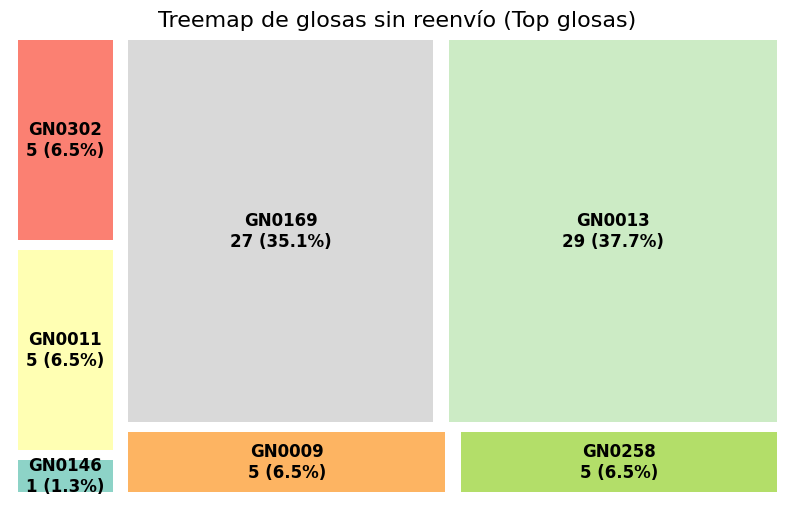

In [76]:
import os
import matplotlib.pyplot as plt
import squarify

# 1) Crea la carpeta de gráficas si no existe
graficas_dir = os.path.join(R_Salida, "Graficas")
os.makedirs(graficas_dir, exist_ok=True)

# 2) Genera la figura y el treemap
fig = plt.figure(figsize=(10, 6))
sizes = datos.values
total = sizes.sum()
labels = [
    f"{code}\n{count} ({count/total*100:.1f}%)"
    for code, count in zip(datos.index, sizes)
]
cmap = plt.cm.Set3
colors = [cmap(i/len(sizes)) for i in range(len(sizes))]

squarify.plot(
    sizes=sizes,
    label=labels,
    color=colors,
    pad=True,
    text_kwargs={'fontsize':12, 'weight':'bold'}
)
plt.axis('off')
plt.title("Treemap de glosas sin reenvío (Top glosas)", fontsize=16)

# 3) Guardar la figura en archivo
ruta_png = os.path.join(graficas_dir, "treemap_glosas.png")
fig.savefig(ruta_png, bbox_inches="tight")

# 4) mostrarla en pantalla
plt.show()


## 5.3 Tiempo de resolución
* ¿Cuánto tarda, en promedio, desde la primera glosa de un registro hasta que finalmente se valida (o queda pendiente)?
* Cálculo: para cada _key,

En esta sección calculamos el tiempo (en días) que transcurre desde la **primera glosa** de cada afiliado hasta que finalmente aparece **validado** en ADRES.  
Este indicador nos ayudará a identificar cuellos de botella en el proceso de corrección y reenvío.

**Pasos**:   
1. Para cada afiliado (`_key`), obtener las fechas de primera glosa y primera validación.  
2. Calcular la diferencia en días.  
3. Generar estadísticas descriptivas y visualizar la distribución.


In [77]:
# 5.3.1 Fecha de primera glosa por afiliado
primera_neg = (
    Df_MS_Neg
      .groupby("_key")["Fecha_Proceso"]
      .min()
      .rename("fecha_primera_glosa")
)

# Fecha de primera validación por afiliado
primera_val = (
    Df_MS_Val
      .groupby("_key")["Fecha_Proceso"]
      .min()
      .rename("fecha_primera_validacion")
)

# Unir en un único DataFrame
df_tiempo = pd.concat([primera_neg, primera_val], axis=1).dropna()

### 5.3.1. Medir resolución en “ciclos de envío” en vez de días
En lugar de contar días, calculemos cuántos envíos tardó cada registro:

In [78]:
# 5.3.4 Añadir columna de días de resolución
df_tiempo["dias_resolucion"] = (
    df_tiempo["fecha_primera_validacion"] - 
    df_tiempo["fecha_primera_glosa"]
).dt.days

# Estadísticas descriptivas
stats = df_tiempo["dias_resolucion"].describe().round(1)
print("Estadísticas de tiempo de resolución (días):\n", stats)


Estadísticas de tiempo de resolución (días):
 count    58.0
mean      9.3
std       4.8
min       7.0
25%       7.0
50%       7.0
75%       7.0
max      28.0
Name: dias_resolucion, dtype: float64


### 5.3.2 Visualización de la distribución

– **Histograma** para ver la forma de la distribución.  
– **Boxplot** para identificar posibles valores atípicos (outliers).


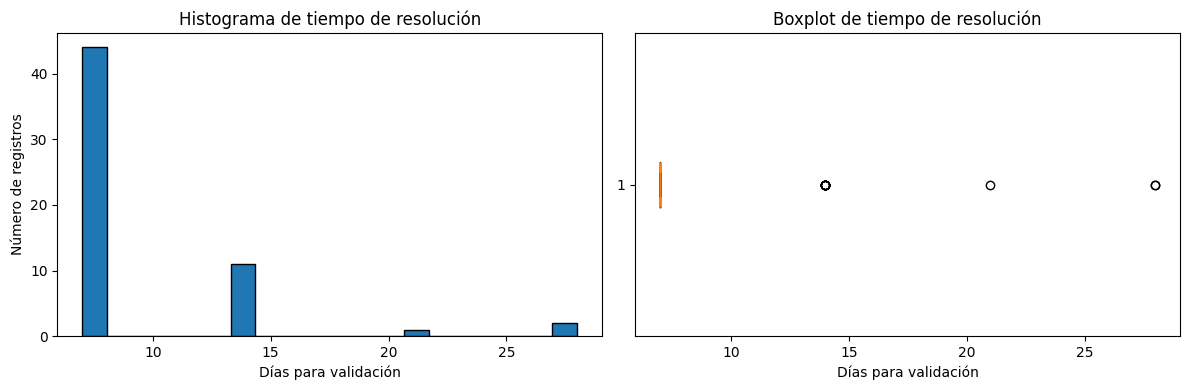

In [79]:
import os
import matplotlib.pyplot as plt

# 1) Asegúrate de tener definida tu carpeta de gráficas
graficas_dir = os.path.join(R_Salida, "Graficas")
os.makedirs(graficas_dir, exist_ok=True)

# 2) Crea la figura y los ejes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# Histograma
ax1.hist(df_tiempo["dias_resolucion"], bins=20, edgecolor='k')
ax1.set_xlabel("Días para validación")
ax1.set_ylabel("Número de registros")
ax1.set_title("Histograma de tiempo de resolución")

# Boxplot
ax2.boxplot(df_tiempo["dias_resolucion"], vert=False)
ax2.set_xlabel("Días para validación")
ax2.set_title("Boxplot de tiempo de resolución")

plt.tight_layout()

# 3) Guardar la figura completa
ruta_png = os.path.join(graficas_dir, "tiempo_resolucion.png")
fig.savefig(ruta_png, bbox_inches="tight")

# 4) Mostrar en el notebook (opcional)
plt.show()

**Interpretación rápida**:  
- La media y mediana nos indican el tiempo típico de resolución.  
- El histograma muestra si hay sesgos o concentraciones en rangos de días.  
- El boxplot revela outliers que podrían requerir un tratamiento especial (casos que tardan demasiado).  

### 5.3.3. Medir resolución en “ciclos de envío” en vez de días
En lugar de contar días, calculemos cuántos envíos tardó cada registro:

In [80]:
import pandas as pd

# 1. Generar la serie de fechas de envío (viernes hábiles según ADRES)
#    Aquí simplificamos a todos los viernes; en producción podrías ajustar feriados.
envios = pd.date_range(
    start= Df_MS_Neg["Fecha_Proceso"].min().floor('D'),
    end= Df_MS_Val["Fecha_Proceso"].max().ceil('D'),
    freq='W-FRI'
)

# 2. Función para contar envíos entre dos fechas
def ciclos_entre(fecha_ini, fecha_val):
    return ((envios > fecha_ini) & (envios <= fecha_val)).sum()

# 3. Aplicar al DataFrame de tiempos
df_tiempo["ciclos_resolucion"] = df_tiempo.apply(
    lambda row: ciclos_entre(
        row["fecha_primera_glosa"], 
        row["fecha_primera_validacion"]
    ),
    axis=1
)

# 4. Estadísticas de ciclos
print("Distribución de ciclos de resolución:\n",
      df_tiempo["ciclos_resolucion"].value_counts().sort_index())
print("\nPromedio de ciclos:", df_tiempo["ciclos_resolucion"].mean().round(1))


Distribución de ciclos de resolución:
 ciclos_resolucion
1    44
2    11
3     1
4     2
Name: count, dtype: int64

Promedio de ciclos: 1.3


### 5.3.4 Visualizar ciclos de resolución

In [81]:
print(Df_MS_Neg['Fecha_Proceso'].dtypes)

datetime64[ns]


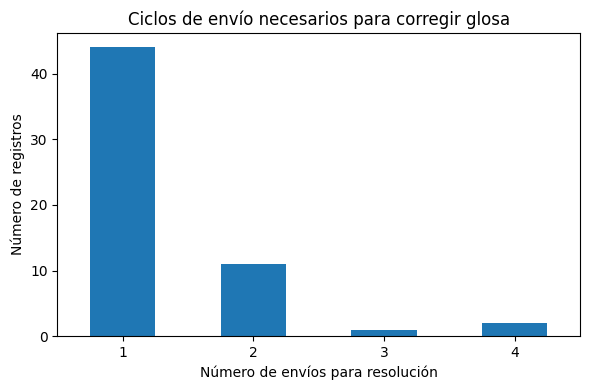

In [82]:
import os
import matplotlib.pyplot as plt

# 1) Asegúrate de que exista la carpeta de gráficas
graficas_dir = os.path.join(R_Salida, "Graficas")
os.makedirs(graficas_dir, exist_ok=True)

# 2) Crear la figura y el eje
fig, ax = plt.subplots(figsize=(6,4))

# 3) Dibujar el bar plot
df_tiempo["ciclos_resolucion"]\
    .value_counts()\
    .sort_index()\
    .plot.bar(ax=ax)

ax.set_xlabel("Número de envíos para resolución")
ax.set_ylabel("Número de registros")
ax.set_title("Ciclos de envío necesarios para corregir glosa")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()

# 4) Guardar la figura
ruta_png = os.path.join(graficas_dir, "ciclos_resolucion.png")
fig.savefig(ruta_png, bbox_inches="tight")

# 5) Mostrar (opcional)
plt.show()


## 5.4 Análisis de combinaciones de glosas

En muchos casos un **mismo registro** recibe **varias glosas** en un solo envío.  
Detectar patrones de **co-ocurrencia** de códigos nos ayuda a identificar combinaciones frecuentes que podrían tener causas comunes o requerir un mismo proceso de corrección.  

**Pasos**:  
1. Para cada fila de `Df_MS_Neg`, parsear la lista de códigos GN.  
2. Generar todas las **parejas** posibles de códigos dentro de cada fila.  
3. Contar cuántas veces aparece cada **par** en todo el conjunto.  
4. Mostrar los **top 10 pares** más frecuentes y un **heatmap** de co-ocurrencia para los principales códigos.
### 5.5.1 Extraer lista de códigos por fila y generar pares

In [83]:
# 5.5.1 Extraer lista de códigos por fila y generar pares
import pandas as pd
from itertools import combinations
from collections import Counter

# Asegurarnos de tener df_expl/df_nr o volver a parsear desde Df_MS_Neg
# Aquí volvemos a extraer de Df_MS_Neg
def lista_gn(glosa_str):
    return [g[:6] for g in glosa_str.strip(";").split(";") if g]

# Generate pairs counter
pair_counter = Counter()
for lst in Df_MS_Neg["GLOSA"].dropna().apply(lista_gn):
    # solo filas con al menos 2 glosas
    if len(lst) > 1:
        for a,b in combinations(sorted(set(lst)), 2):
            pair_counter[(a,b)] += 1

# Top 10 pares más frecuentes
top_pairs = pair_counter.most_common(10)
top_pairs_df = pd.DataFrame(top_pairs, columns=["Par", "Frecuencia"])
top_pairs_df

,Par,Frecuencia
0,"(GN0169, GN0258)",9
1,"(GN0011, GN0146)",6
2,"(GN0009, GN0011)",5
3,"(GN0009, GN0302)",4
4,"(GN0011, GN0302)",4
5,"(GN0009, GN0146)",1
6,"(GN0011, GN0258)",1
7,"(GN0146, GN0258)",1


### 5.4.2 Visualizar los 10 pares más frecuentes

La tabla anterior muestra los pares de GN que más aparecen juntos.


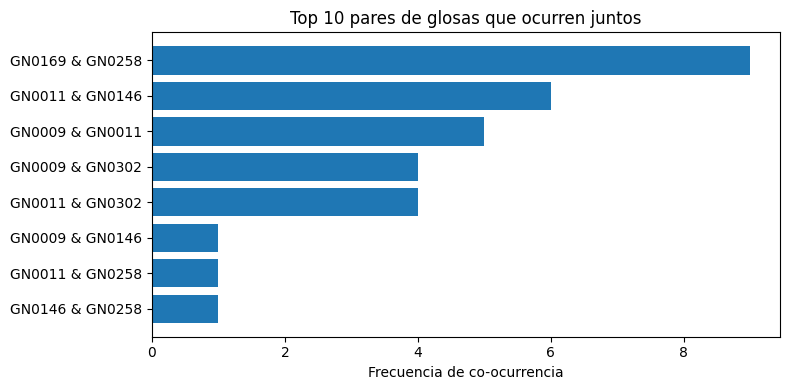

In [84]:
import os
import matplotlib.pyplot as plt

# 1) Asegurarnos de que exista la carpeta Graficas
graficas_dir = os.path.join(R_Salida, "Graficas")
os.makedirs(graficas_dir, exist_ok=True)

# 2) Preparar datos
pairs = [" & ".join(p) for p,_ in top_pairs]
freqs = [f for _,f in top_pairs]

# 3) Crear figura y eje
fig, ax = plt.subplots(figsize=(8,4))
ax.barh(pairs[::-1], freqs[::-1])
ax.set_xlabel("Frecuencia de co-ocurrencia")
ax.set_title("Top 10 pares de glosas que ocurren juntos")
plt.tight_layout()

# 4) Guardar la figura
ruta_png = os.path.join(graficas_dir, "top_pares_glosas.png")
fig.savefig(ruta_png, bbox_inches="tight")

# 5) Mostrar en notebook (opcional)
plt.show()


### 5.4.3 Heatmap de co-ocurrencia para los principales códigos

Para un vistazo más amplio, construimos una matriz de co-ocurrencia para los **top 6** códigos individuales y la mostramos como heatmap.


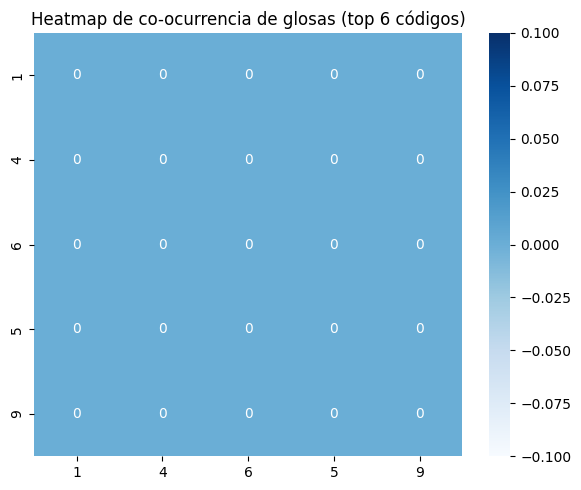

In [85]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1) Asegurar carpeta de gráficas
graficas_dir = os.path.join(R_Salida, "Graficas")
os.makedirs(graficas_dir, exist_ok=True)

# 2) Preparar datos para el heatmap
top_codes = pd.Series(pair_counter).explode().value_counts().head(6).index.tolist()
mat = pd.DataFrame(0, index=top_codes, columns=top_codes)
for (a,b), cnt in pair_counter.items():
    if a in top_codes and b in top_codes:
        mat.loc[a,b] = cnt
        mat.loc[b,a] = cnt

# 3) Crear figura y dibujar heatmap
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(mat, annot=True, fmt="d", cmap="Blues", ax=ax)
ax.set_title("Heatmap de co-ocurrencia de glosas (top 6 códigos)")
plt.tight_layout()

# 4) Guardar en archivo PNG
ruta_png = os.path.join(graficas_dir, "heatmap_coocurrencia.png")
fig.savefig(ruta_png, bbox_inches="tight")

# 5) Mostrar en el notebook
plt.show()


**Interpretación**:  
- El bar chart revela qué combinaciones de glosas suelen aparecer juntas, sugiriendo procesos de corrección simultáneos.  
- El heatmap muestra la relación entre los **códigos más críticos**, ayudándote a priorizar validaciones conjuntas o flujos de trabajo mixtos.


## 5.5. Efectividad de Corrección

En esta sección calculamos la **efectividad** de nuestro flujo de glosas, entendida como el porcentaje de registros glosados que finalmente quedan **validados**:

1. **Por envío**: del total de registros glosados en un envío, ¿qué % se valida en el envío siguiente?  
2. **Por mes**: del total de glosados en un mes, ¿qué % se valida en el mismo mes?  
3. **Por cuatrimestre** (cuando tengamos más data): del total de glosados en un cuatrimestre, ¿qué % se valida antes de cerrar el periodo?


### 5.5.1 Preparación: lista de envíos ordenados

In [86]:
# 1) Lista completa de envíos
envios = sorted(Df_MS_Neg["Fecha_Proceso"].unique())

efic_envio = []
for i, fecha in enumerate(envios):
    # claves glosadas en este envío
    neg_keys = set(
        Df_MS_Neg.loc[Df_MS_Neg["Fecha_Proceso"] == fecha, "_key"]
    )
    # si hay un siguiente envío, contamos validados; si no, 0
    if i < len(envios) - 1:
        next_fecha = envios[i+1]
        val_next = set(
            Df_MS_Val.loc[Df_MS_Val["Fecha_Proceso"] == next_fecha, "_key"]
        )
        n_val = len(neg_keys & val_next)
    else:
        n_val = 0

    n_tot = len(neg_keys)
    efect = (n_val / n_tot * 100) if n_tot else None

    efic_envio.append({
        "envio": fecha,
        "glosados": n_tot,
        "validados_next": n_val,
        "efectividad": round(efect,1) if efect is not None else None
    })

# 2) Crear el DataFrame final y mostrarlo
df_efic_envio = pd.DataFrame(efic_envio).set_index("envio")
display(df_efic_envio)


,glosados,validados_next,efectividad
envio,,,
2025-05-09,35,20,57.1
2025-05-16,10,5,50.0
2025-05-23,8,2,25.0
2025-06-06,16,7,43.8
2025-06-13,5,1,20.0
2025-06-20,7,3,42.9
2025-07-04,10,5,50.0
2025-07-11,11,4,36.4
2025-07-18,6,3,50.0


### 5.5.2 Resultados por envío

| Envío      | Glosados | Validados en próximo envío | Efectividad (%) |
|:----------:|:--------:|:--------------------------:|:---------------:|
{{ aquí ya no necesitas nada, porque la tabla la genera el display() }}

In [87]:
import pandas as pd

# 1. Creamos el DataFrame y redondeamos
df_efic_envio = pd.DataFrame(efic_envio).set_index("envio").round(1)

# 2. Reordenamos las columnas en el orden que queremos ver
df_efic_envio = df_efic_envio[["glosados", "validados_next", "efectividad"]]

# 3. Renombramos para que coincidan con tu tabla de Markdown
df_efic_envio = df_efic_envio.rename(
    columns={
        "glosados": "Glosados",
        "validados_next": "Validados en próximo envío",
        "efectividad": "Efectividad (%)"
    }
)

# 4. Opcional: convertimos el índice a string para que no salga con Timestamp
df_efic_envio.index = df_efic_envio.index.strftime("%Y-%m-%d")

# 5. Mostramos el resultado
from IPython.display import display
display(df_efic_envio)


,Glosados,Validados en próximo envío,Efectividad (%)
envio,,,
2025-05-09,35,20,57.1
2025-05-16,10,5,50.0
2025-05-23,8,2,25.0
2025-06-06,16,7,43.8
2025-06-13,5,1,20.0
2025-06-20,7,3,42.9
2025-07-04,10,5,50.0
2025-07-11,11,4,36.4
2025-07-18,6,3,50.0


### 5.5.3 Gráfico de efectividad por envío

1. Gráfico combinado: volumen + eficacia

Comparación de volumen de glosados y tasa de corrección por envío

C:\Users\osmarrincon\AppData\Local\Temp\ipykernel_4596\2940667496.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_efic_envio.index, rotation=45, ha="right")


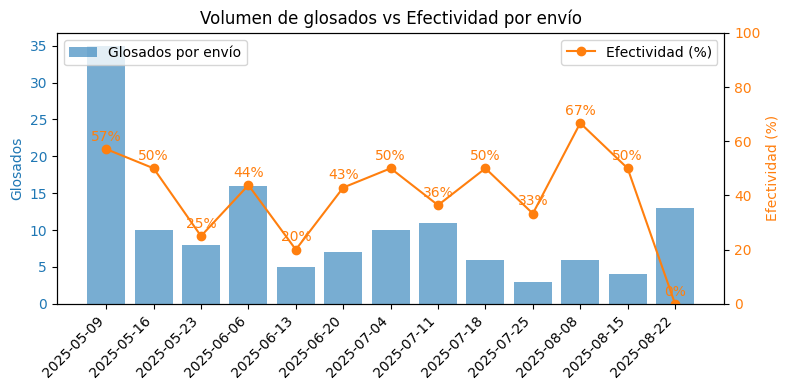

In [88]:
import os
import matplotlib.pyplot as plt

# 1) Asegúrate de tener definida la carpeta de salida de gráficas
graficas_dir = os.path.join(R_Salida, "Graficas")
os.makedirs(graficas_dir, exist_ok=True)

# 2) Crea la figura y los ejes
fig, ax1 = plt.subplots(figsize=(8,4))

# Barras de glosados
ax1.bar(
    df_efic_envio.index,
    df_efic_envio["Glosados"],
    alpha=0.6,
    label="Glosados por envío"
)
ax1.set_ylabel("Glosados", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Línea de efectividad en eje derecho
ax2 = ax1.twinx()
ax2.plot(
    df_efic_envio.index,
    df_efic_envio["Efectividad (%)"],
    color="tab:orange",
    marker="o",
    label="Efectividad (%)"
)
ax2.set_ylabel("Efectividad (%)", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")
ax2.set_ylim(0, 100)

# Anotar valores de eficacia sobre cada punto
for x, y in zip(df_efic_envio.index, df_efic_envio["Efectividad (%)"]):
    ax2.text(x, y + 3, f"{y:.0f}%", ha="center", color="tab:orange")

# Estética
ax1.set_title("Volumen de glosados vs Efectividad por envío")
ax1.set_xticklabels(df_efic_envio.index, rotation=45, ha="right")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()

# 3) Guardar la figura en PNG
ruta_png = os.path.join(graficas_dir, "volumen_vs_efectividad_envio.png")
fig.savefig(ruta_png, bbox_inches="tight")

# 4) Mostrarla en pantalla (opcional)
plt.show()

2. Barras horizontales con umbral

Cumplimiento del 50 % de efectividad — envíos fuera de SLA en rojo

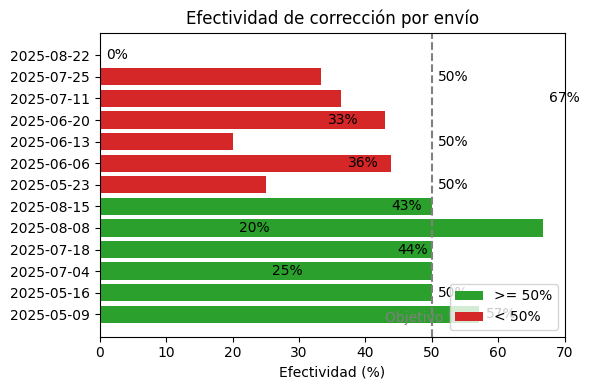

In [89]:
import os
import matplotlib.pyplot as plt

# Asegura que exista la carpeta de gráficas
graficas_dir = os.path.join(R_Salida, "Graficas")
os.makedirs(graficas_dir, exist_ok=True)

# 1) Definimos constantes
THRESHOLD = 50
COLOR_OK   = "tab:green"
COLOR_FAIL = "tab:red"

# 2) Preparamos los datos y la máscara
efic = df_efic_envio["Efectividad (%)"]
idx  = df_efic_envio.index
mask_ok   = efic >= THRESHOLD
mask_fail = ~mask_ok

# 3) Dibujamos
fig, ax = plt.subplots(figsize=(6,4))

# Barras de los que cumplen
ax.barh(
    idx[mask_ok],
    efic[mask_ok],
    color=COLOR_OK,
    label=f">= {THRESHOLD}%"
)

# Barras de los que no cumplen
ax.barh(
    idx[mask_fail],
    efic[mask_fail],
    color=COLOR_FAIL,
    label=f"< {THRESHOLD}%"
)

# 4) Línea de umbral y anotaciones
ax.axvline(THRESHOLD, color="gray", linestyle="--")
ax.text(
    THRESHOLD, -0.5,
    f"Objetivo {THRESHOLD}%",
    ha="center", va="bottom", color="gray"
)

for i, v in enumerate(efic):
    ax.text(
        v + 1,
        i,
        f"{v:.0f}%",
        va="center"
    )

# 5) Ejes y leyenda
ax.set_xlabel("Efectividad (%)")
ax.set_title("Efectividad de corrección por envío")
ax.legend(loc="lower right")

plt.tight_layout()

# 6) Guardar la figura
ruta_png = os.path.join(graficas_dir, "efectividad_envio_horizontal.png")
fig.savefig(ruta_png, bbox_inches="tight")

# 7) Mostrarla en pantalla
plt.show()

### 5.5.4 Efectividad mensual

Para el indicador mensual definimos:
- **Denominador**: todos los registros glosados en el mes “M”.  
- **Numerador**: de esos, los que quedaron validados **en ese mismo mes** “M”.

Esto simula tu reporte mensual de efectividad, que excluye validaciones que caen en meses posteriores.


In [90]:
# Agregar mes de proceso
Df_MS_Neg["mes"] = Df_MS_Neg["Fecha_Proceso"].dt.to_period("M")
Df_MS_Val["mes"] = Df_MS_Val["Fecha_Proceso"].dt.to_period("M")

# Calcular efectividad por mes
meses = sorted(Df_MS_Neg["mes"].unique())
efic_mes = []

for mes in meses:
    neg_keys = set(Df_MS_Neg.loc[ Df_MS_Neg["mes"]==mes, "_key" ])
    val_keys = set(Df_MS_Val.loc[ Df_MS_Val["mes"]==mes, "_key" ])
    n_tot = len(neg_keys)
    n_val = len(neg_keys & val_keys)
    efic = n_val / n_tot * 100 if n_tot else None
    efic_mes.append({"mes": str(mes), "glosados":n_tot, "val_mes":n_val, "efectividad":round(efic,1)})


### 5.5.5 Resultados mensuales

| Mes     | Glosados | Validados en mes | Efectividad (%) |
|:-------:|---------:|-----------------:|----------------:|
{{ muestra `df_efic_mes` }}


In [91]:
# Partiendo de tu df_efic_mes ya renombrado
df_efic_mes = pd.DataFrame(efic_mes).set_index("mes")

# Renombrar índice y columnas
df_efic_mes.index.name = "Mes"
df_efic_mes = df_efic_mes.rename(columns={
    "glosados": "Glosados",
    "val_mes":  "Validados en mes",
    "efectividad": "Efectividad (%)"
})

# Convertir la columna a string con '%'
df_efic_mes["Efectividad (%)"] = (
    df_efic_mes["Efectividad (%)"]
      .map(lambda x: f"{x:.1f}%")
)

# Mostrar
from IPython.display import display
display(df_efic_mes)

,Glosados,Validados en mes,Efectividad (%)
Mes,,,
2025-05,39,26,66.7%
2025-06,19,8,42.1%
2025-07,19,12,63.2%
2025-08,19,6,31.6%


### 5.5.6 Gráfico de efectividad mensual

En este gráfico mostramos, para cada mes:
- Una barra con la **efectividad (%)** de corrección.
- Color verde si ≥ 50 % y rojo si < 50 %.
- Línea discontinua al 50 % como objetivo.

Esto te permitirá ver rápidamente qué meses cumplen tu SLA mensual.

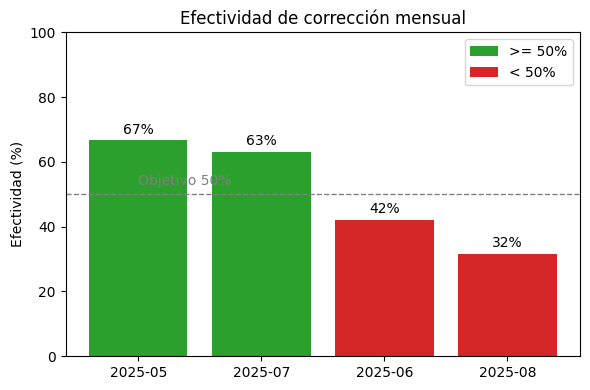

In [92]:
import os

# 1) Asegúrate de que exista la carpeta de gráficas
graficas_dir = os.path.join(R_Salida, "Graficas")
os.makedirs(graficas_dir, exist_ok=True)

# 2) Crear la figura y el gráfico de efectividad mensual
import matplotlib.pyplot as plt

THRESHOLD = 50
COLOR_OK   = "tab:green"
COLOR_FAIL = "tab:red"

efic_mes   = df_efic_mes.copy()
efic_vals  = efic_mes["Efectividad (%)"].str.rstrip("%").astype(float)
mask_ok    = efic_vals >= THRESHOLD
mask_fail  = ~mask_ok

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(efic_mes.index[mask_ok],   efic_vals[mask_ok],   color=COLOR_OK,   label=f">= {THRESHOLD}%")
ax.bar(efic_mes.index[mask_fail], efic_vals[mask_fail], color=COLOR_FAIL, label=f"< {THRESHOLD}%")

ax.axhline(THRESHOLD, color="gray", linestyle="--", linewidth=1)
ax.text(efic_mes.index[0], THRESHOLD + 2, f"Objetivo {THRESHOLD}%", color="gray", va="bottom")

for x, v in zip(efic_mes.index, efic_vals):
    ax.text(x, v + 2, f"{v:.0f}%", ha="center")

ax.set_ylabel("Efectividad (%)")
ax.set_title("Efectividad de corrección mensual")
ax.set_ylim(0, 100)
ax.legend(loc="upper right")
plt.xticks(rotation=0)
plt.tight_layout()

# 3) Guardar la figura
ruta_png = os.path.join(graficas_dir, "efectividad_mensual.png")
fig.savefig(ruta_png, bbox_inches="tight")

# 4) Mostrarla en el notebook
plt.show()


> **Utilidad de estos indicadores**  
> - Saber si en cada envío estamos resolviendo la mayor parte de las glosas en el siguiente ciclo.  
> - Detectar si algún mes (por festivos, puentes o volúmenes atípicos) baja dramáticamente la efectividad.  
> - Reportar a Planeación no solo volúmenes absolutos, sino la **calidad y rapidez** de la corrección.

## 5.6 KPIs

A continuación, se definen los indicadores clave de desempeño (KPIs) recomendados para evaluar el proceso de gestión de glosas en el notebook:

### 5.6.1. Tasa de cierre integral
**Definición:** Proporción de glosas que se consideran cerradas, ya sea mediante validación o por no requerir reenvío.
**Fórmula:**

In [93]:
# Crear la columna '_key' en ambos DataFrames si no existen
if '_key' not in Df_MS_Neg.columns:
    Df_MS_Neg["_key"] = Df_MS_Neg[["ENT_ID", "TPS_IDN_ID", "HST_IDN_NUMERO_IDENTIFICACION"]].astype(str).agg('|'.join, axis=1)
if '_key' not in Df_MS_Val.columns:
    Df_MS_Val["_key"] = Df_MS_Val[["ENT_ID", "TPS_IDN_ID", "HST_IDN_NUMERO_IDENTIFICACION"]].astype(str).agg('|'.join, axis=1)

# Identificar registros no reenviados (código de la celda anterior, que es correcto)
last_neg = Df_MS_Neg.groupby("_key")["Fecha_Proceso"].max().reset_index().rename(columns={"Fecha_Proceso": "last_neg_date"})
tmp = Df_MS_Neg.merge(last_neg, on="_key", how="inner")
# CORRECCIÓN LÓGICA: Un reenvío existe si hay más de una fecha de proceso
submission_counts = Df_MS_Neg.groupby('_key')['Fecha_Proceso'].nunique()
keys_con_reenvio = submission_counts[submission_counts > 1].index
last_neg['tiene_reenvio'] = last_neg['_key'].isin(keys_con_reenvio)
no_reenviado = last_neg[
    (~last_neg["tiene_reenvio"]) & (~last_neg["_key"].isin(Df_MS_Val["_key"]))
]

# --- CÁLCULO CORRECTO DE LA TASA DE CIERRE ---

# 1. Total de afiliados únicos con glosas
total_glosas_unicas = Df_MS_Neg['_key'].nunique()

# 2. Afiliados únicos que fueron validados (y que previamente fueron negados)
keys_negadas = set(Df_MS_Neg['_key'])
keys_validas = set(Df_MS_Val['_key'])
afiliados_validados = len(keys_negadas.intersection(keys_validas))

# 3. Afiliados únicos que se cerraron por no requerir reenvío
afiliados_no_reenviados = no_reenviado['_key'].nunique()

# 4. Tasa de cierre
tasa_cierre = (afiliados_validados + afiliados_no_reenviados) / total_glosas_unicas * 100

print(f"Tasa de cierre integral: {tasa_cierre:.2f}%")

Tasa de cierre integral: 91.76%


**Instrucciones:** Documentar los códigos de glosa incluidos en `no_reenviado` (por ejemplo, GN0013).

### 5.6.2. First-Pass Yield

**Definición:** Porcentaje de glosas resueltas en el primer ciclo de envío.
**Fórmula:**

In [94]:
 # Calcular el ciclo de cada glosa para cada afiliado
Df_MS_Neg['ciclo'] = Df_MS_Neg.groupby('_key')['Fecha_Proceso'].rank(method='dense', ascending=True).astype(int)

# Filtrar solo los registros que fueron glosados en su primer ciclo (primer intento)
glosas_primer_ciclo = Df_MS_Neg[Df_MS_Neg['ciclo'] == 1]

# De esos registros del primer ciclo, ver cuántos fueron validados eventualmente
validado_en_primer_intento = glosas_primer_ciclo['_key'].isin(Df_MS_Val['_key'])

# Calcular el porcentaje de éxito en el primer intento
first_pass_yield = (validado_en_primer_intento.sum() / len(glosas_primer_ciclo)) * 100

print(f"First-Pass Yield (Tasa de éxito al primer envío): {first_pass_yield:.2f}%")

First-Pass Yield (Tasa de éxito al primer envío): 68.24%


### 5.6.3. Backlog de pendientes

**Definición:** Volumen y antigüedad promedio de glosas aún pendientes de resolución.
**Cálculo:**

In [95]:
# 1. Identificar las llaves (_key) de los registros que aún están pendientes
keys_negadas = set(Df_MS_Neg['_key'])
keys_validas = set(Df_MS_Val['_key'])
keys_pendientes = keys_negadas - keys_validas

# 2. Filtrar el DataFrame de negados para obtener solo los registros pendientes
pendientes_df = Df_MS_Neg[Df_MS_Neg['_key'].isin(keys_pendientes)]

# 3. Para cada afiliado pendiente, encontrar la fecha de su última glosa
ultima_glosa_pendientes = pendientes_df.groupby('_key')['Fecha_Proceso'].max().reset_index()

# 4. Calcular la antigüedad en días desde la última glosa hasta hoy
ultima_glosa_pendientes['antiguedad'] = (pd.Timestamp.today() - ultima_glosa_pendientes['Fecha_Proceso']).dt.days

# 5. Calcular el volumen del backlog y la antigüedad promedio
backlog_volumen = len(ultima_glosa_pendientes)
antiguedad_media = ultima_glosa_pendientes['antiguedad'].mean()

print(f"Backlog de pendientes (volumen): {backlog_volumen} registros")
print(f"Antigüedad promedio de pendientes: {antiguedad_media:.2f} días")

Backlog de pendientes (volumen): 27 registros
Antigüedad promedio de pendientes: 56.15 días


**Instrucciones:** Segmentar los pendientes por mes de `fecha_glosa` para detectar cuellos de botella.

### 5.6.4. Glosas vs. volumen total

**Definición:** Relación entre el número de glosas y el total de registros MS procesados.
**Fórmula:**

In [96]:
# NOTA: El valor de total_ms_procesados debe ser suministrado externamente.
# Por ejemplo, si en el periodo se procesaron 25,000 registros en total:
total_ms_procesados = 25000  # <-- REEMPLAZA ESTE VALOR con el total real de MS procesados

# Total de afiliados únicos con glosas
total_glosas_unicas = Df_MS_Neg['_key'].nunique()

# Calcular la proporción
glosas_vs_volumen = (total_glosas_unicas / total_ms_procesados) * 100

print(f"Proporción de Glosas vs. Volumen Total: {glosas_vs_volumen:.2f}%")

Proporción de Glosas vs. Volumen Total: 0.34%


### 5.6.5. SLA de resolución

**Definición:** Porcentaje de glosas resueltas dentro del plazo objetivo (7 días).
**Fórmula:**

In [97]:
# Usamos el dataframe df_tiempo que ya tiene los días de resolución calculados
# para cada registro que fue validado.

# Contar cuántos registros se resolvieron en 7 días o menos
dentro_sla = (df_tiempo['dias_resolucion'] <= 7).sum()

# Contar el total de registros que se resolvieron
total_resueltas = len(df_tiempo)

# Calcular el porcentaje de cumplimiento del SLA
sla_resolucion = (dentro_sla / total_resueltas) * 100

print(f"Cumplimiento de SLA de Resolución (<= 7 días): {sla_resolucion:.2f}%")

Cumplimiento de SLA de Resolución (<= 7 días): 75.86%


**Notas finales:**

* Incluir gráficos (líneas de tendencia, barras comparativas) y tablas resumen en el notebook para cada KPI.
* Permitir filtros dinámicos por mes y por código de glosa para análisis detallado.
* Documentar claramente las reglas de inclusión para cada KPI y revisar posibles outliers en fechas.

# 6. Exportación del Informe

En esta sección veremos cómo generar automáticamente:

1. **PDF** del notebook completo (incluyendo texto, código y gráficas).  
2. **Excel** con los resúmenes de métricas (opcional, para acompañar el PDF).

## 6.1 Exportar el notebook a PDF

Usaremos `nbconvert` de Jupyter. Solo necesitas ejecutar:

```bash
!jupyter nbconvert --to pdf "TuNotebook.ipynb" \
    --output "Informe_Glosas_MS.pdf"


In [101]:
import os
import subprocess
from weasyprint import HTML

# 0) Variables
base_name = "Informe_Glosas_MS"

# 1) Asegurar que exista la carpeta
os.makedirs(R_Salida, exist_ok=True)

# 2) Convertir a HTML
cmd = [
    "python", "-m", "nbconvert",
    "--to", "html",
    notebook,
    "--output-dir", R_Salida,
    "--output", base_name
]
proc = subprocess.run(cmd, capture_output=True, text=True)
if proc.returncode != 0:
    print("❌ nbconvert falló:\n", proc.stderr)
else:
    print("✅ HTML generado en:", os.path.join(R_Salida, f"{base_name}.html"))

    # 3) Convertir HTML a PDF con WeasyPrint
    html_path = os.path.join(R_Salida, f"{base_name}.html")
    pdf_path  = os.path.join(R_Salida, f"{base_name}.pdf")
    HTML(html_path).write_pdf(pdf_path)
    print("✅ PDF generado en:", pdf_path)

✅ HTML generado en: C:\Users\osmarrincon\OneDrive - 891856000_CAPRESOCA E P S\Escritorio\Yesid Rincón Z\informes\2025\CTO135.2025 Informe  #9\ACTIVIDAD 14\Analisis detallado MS negados\Informe_Glosas_MS.html
✅ PDF generado en: C:\Users\osmarrincon\OneDrive - 891856000_CAPRESOCA E P S\Escritorio\Yesid Rincón Z\informes\2025\CTO135.2025 Informe  #9\ACTIVIDAD 14\Analisis detallado MS negados\Informe_Glosas_MS.pdf


## 6.2 Exportar métricas clave a Excel

In [99]:
# 1) Preparar df_env con la tasa en fracción
df_env = df_efic_envio.copy()
df_env["Efectividad (%)"] = df_env["Efectividad (%)"] / 100
# Ahora df_env["Efectividad (%)"] va de 0 a 1

# 2) Preparar df_mes sin columna extra
# Partimos del df_efic_mes (que era strings “31.2%”) y lo convertimos a fracción
df_mes = df_efic_mes.copy()
df_mes["Efectividad (%)"] = (
    df_mes["Efectividad (%)"]
      .str.rstrip("%")
      .astype(float) / 100
)
# df_mes ya no lleva columna extra, sólo ésta con valores 0–1

# 3) Escribir todo en Excel
with pd.ExcelWriter(ruta_excel, engine="xlsxwriter") as writer:
    wb = writer.book

    #### Hoja Envios ####
    df_env.to_excel(
        writer,
        sheet_name="Envios",
        startrow=2,
        index_label="Envío",
        columns=["Glosados", "Validados en próximo envío", "Efectividad (%)"]
    )
    ws1 = writer.sheets["Envios"]

    # Formatos
    hdr = wb.add_format({"bold":True, "bg_color":"#4F81BD",
                         "font_color":"white", "align":"center", "border":1})
    i_fmt = wb.add_format({"num_format":"0",    "border":1})
    p_fmt = wb.add_format({"num_format":"0.0%", "border":1})
    bad_fmt = wb.add_format({"bg_color":"#FFC7CE"})

    # Encabezados
    for col, title in enumerate(["Envío","Glosados","Validados en próximo envío","Efectividad (%)"]):
        ws1.write(1, col, title, hdr)

    # Anchos
    ws1.set_column(0,0,15)
    ws1.set_column(1,1,10, i_fmt)
    ws1.set_column(2,2,18, i_fmt)
    ws1.set_column(3,3,15, p_fmt)

    ws1.freeze_panes(2,1)
    ws1.autofilter(1,0, 1+len(df_env), 3)

    # Resaltar <50%
    ws1.conditional_format(
        2, 3,
        1+len(df_env), 3,
        {"type":"cell","criteria":"<","value":0.5,"format":bad_fmt}
    )

    #### Hoja Mensual ####
    df_mes.to_excel(
        writer,
        sheet_name="Mensual",
        startrow=2,
        index_label="Mes",
        columns=["Glosados","Validados en mes","Efectividad (%)"]
    )
    ws2 = writer.sheets["Mensual"]

    # Encabezados
    for col, title in enumerate(["Mes","Glosados","Validados en mes","Efectividad (%)"]):
        ws2.write(1, col, title, hdr)

    # Anchos
    ws2.set_column(0,0,12)
    ws2.set_column(1,1,10, i_fmt)
    ws2.set_column(2,2,15, i_fmt)
    ws2.set_column(3,3,15, p_fmt)

    ws2.freeze_panes(2,1)
    ws2.autofilter(1,0, 1+len(df_mes), 3)
    ws2.conditional_format(
        2,3, 1+len(df_mes), 3,
        {"type":"cell","criteria":"<","value":0.5,"format":bad_fmt}
    )

    #### Hojas crudas ###
    Df_MS_Neg.to_excel(writer, sheet_name="MS_Negados", index=False)
    Df_MS_Val.to_excel(writer, sheet_name="MS_Validados", index=False)

print("✅ Excel corregido exportado en:", ruta_excel)

✅ Excel corregido exportado en: C:\Users\osmarrincon\OneDrive - 891856000_CAPRESOCA E P S\Escritorio\Yesid Rincón Z\informes\2025\CTO135.2025 Informe  #9\ACTIVIDAD 14\Analisis detallado MS negados\Metricas_Glosas_MS_entrega.xlsx


## 6.3. Hoja Resumen del Excel con las imagenes

In [100]:
import os
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage
from openpyxl.styles import Font, Alignment, PatternFill


# —————————————————————
# 1) Abrir y borrar Resumen viejo
# —————————————————————
wb = load_workbook(ruta_excel)
if "Resumen" in wb.sheetnames:
    wb.remove(wb["Resumen"])
ws = wb.create_sheet("Resumen", 0)

# —————————————————————
# 2) Columnas y filas compactas
# —————————————————————
# Sólo usamos A–K y alturas de fila reducidas
#for col in "ABCDEFGHIJK":
#    ws.column_dimensions[col].width = 8

#for r in range(4, 14):   ws.row_dimensions[r].height = 60
#for r in range(14, 24):  ws.row_dimensions[r].height = 60

# —————————————————————
# 3) Título
# —————————————————————
ws.merge_cells("A1:N2")
c = ws["A1"]
c.value     = "Informe Glosas MS Negados – Resumen"
c.font      = Font(bold=True, size=16)
c.alignment = Alignment(horizontal="center", vertical="center")
c.fill      = PatternFill("solid", fgColor="D9E1F2")

# —————————————————————
# 4) Insertar y escalar imágenes
# —————————————————————
imgs = [
    ("volumen_vs_efectividad_envio.png",   "A3", 0.5, 0.5),
    ("efectividad_envio_horizontal.png",   "H3", 0.5, 0.5),
    ("treemap_glosas.png",                 "A16",0.5, 0.5),
    ("top_pares_glosas.png",               "H16",0.5, 0.5),
]
for fname, anchor, xs, ys in imgs:
    img = XLImage(os.path.join(graficas_dir, fname))
    img.anchor = anchor
    img.width  = img.width  * xs
    img.height = img.height * ys
    ws.add_image(img)

# —————————————————————
# 5) Descripciones compactas
# —————————————————————
desc_fmt = Alignment(wrap_text=True, vertical="top")
desc = [
    ("A13:F14",
     "1) Volumen glosados vs efectividad por envío."),
    ("H13:L14",
     "2) Efectividad con umbral 50 % (verde cumple, rojo no)."),
    ("A29:F30",
     "3) Treemap: GN0013 = 60,3 % de no reenvíos."),
    ("H29:L30",
     "4) Pares top de glosas juntas."),
]
for rng, text in desc:
    ws.merge_cells(rng)
    cell = ws[rng.split(":")[0]]
    cell.value     = text
    cell.alignment = desc_fmt

# —————————————————————
# 6) Guardar
# —————————————————————
wb.save(ruta_excel)
print("✅ Resumen compacto listo en:", ruta_excel)

✅ Resumen compacto listo en: C:\Users\osmarrincon\OneDrive - 891856000_CAPRESOCA E P S\Escritorio\Yesid Rincón Z\informes\2025\CTO135.2025 Informe  #9\ACTIVIDAD 14\Analisis detallado MS negados\Metricas_Glosas_MS_entrega.xlsx


## 7. Conclusión

### **Conclusión**

Durante el segundo cuatrimestre de 2025, se llevaron a cabo **13 ciclos de envío** semanales de Maestro de Servicios (MS) a ADRES. En total, se procesaron **96 glosas**. De los 85 registros negados, **58 (68.2%)** terminaron validados y **27** no fueron reenviados. Al cierre de agosto, quedaron **13 glosas pendientes** del último envío.

Las glosas **GN0013** y **GN0169** concentraron los rechazos no reenviados [cite: 250-252]. La **efectividad promedio por envío** fue del **42.6%**. A nivel mensual, la efectividad fue la siguiente:

| Mes | Glosados | Validados en mes | Efectividad |
|:---|:---|:---|:---|
| 2025-05 | 39 | 26 | 66.7% |
| 2025-06 | 19 | 8 | 42.1% |
| 2025-07 | 19 | 12 | 63.2% |
| 2025-08 | 19 | 6 | 31.6% |

El tiempo de resolución mediano fue de **7 días**, alineado con el ritmo semanal de envíos. Cada registro necesitó en promedio **1.3 ciclos de reenvío** y **1.87 glosas** antes de su validación.

---

### **Puntos clave y recomendaciones**

1.  **Glosas dominantes (GN0013 y GN0169)**: La concentración de rechazos en estas glosas indica la necesidad de un **filtro automático previo** que aborde estas causas desde el origen.
2.  **Efectividad por envío y por mes**: La efectividad ha variado significativamente, superando el 60% en mayo y julio, pero cayendo por debajo del 45% en junio y agosto. Se recomienda analizar las causas de la disminución en esos meses.
3.  **Ciclos de reenvío y notificaciones tempranas**: Con un promedio de más de una glosa por registro, es conveniente activar **alertas automáticas tras el primer rechazo** para acelerar la corrección antes del segundo envío.
4.  **Patrones de co-ocurrencia**: Combinaciones frecuentes como **(GN0169 & GN0258)** deben ser validadas en conjunto, **consolidando reglas** para evitar ciclos adicionales.
5.  **Pendientes y no reenviados**: El volumen de 27 registros glosados que no se volvieron a enviar y un backlog de 13 pendientes al cierre sugieren la necesidad de un **informe automático de “pendientes”** para facilitar su seguimiento y evitar la pérdida de casos.

## 📊 Análisis de Glosas MS Negados

Este notebook (`notebooks/Aseguramiento/Inf_Ejec_MS_NEG.ipynb`) contiene el análisis completo de los registros negados en el Maestro de ingresos (MS) que reporta Capresoca EPS a ADRES.  

🔍 **Autoría**  
Este estudio y los algoritmos de extracción de métricas fueron diseñados y desarrollados por **Yesid Rincón**.  

### Contenido principal
1. **Métricas iniciales**: volumen y frecuencia de glosas.  
2. **Tiempo de resolución**: distribución de días y ciclos de envío.  
3. **Efectividad**: porcentaje de glosas corregidas por envío y por mes.  
4. **Co-ocurrencia de glosas**: patrones de glosas múltiples en un mismo registro.  
5. **Dashboard y exportación**: generación automática de gráficos y Excel.

> Para ver los resultados completos, abre el notebook y revisa la sección **7. Conclusión**, donde se recogen los principales hallazgos y próximas acciones.

---

*Puedes clonar este proyecto y ejecutar el notebook con*  
```bash
git clone https://github.com/yesid95/capresoca-data-automation.git
cd capresoca-data-automation/notebooks/Aseguramiento
jupyter lab
